In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import dask
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import cartopy as cy
from functions import trend
%matplotlib inline

In [2]:
path='../../Data/ds_zeppelin_2010_2019.nc'
ds = xr.open_dataset(path)

In [3]:
len(ds.time_traj.values)


96

In [4]:
ds

<xarray.Dataset>
Dimensions:            (D: 33, time: 53132, time_traj: 96)
Coordinates:
  * D                  (D) float64 10.0 11.22 12.59 14.12 ... 316.2 354.8 398.1
  * time               (time) datetime64[ns] 2010-08-03 ... 2019-12-31T23:00:00
  * time_traj          (time_traj) int64 0 1 2 3 4 5 6 ... 89 90 91 92 93 94 95
Data variables:
    pnsd               (time, D) float64 ...
    pnsd_nolog         (time, D) float64 ...
    conc_10_50         (time) float64 ...
    conc_50_100        (time) float64 ...
    conc_100_400       (time) float64 ...
    condensation_sink  (time) float64 ...
    Rainfall           (time, time_traj) float64 ...
    Solar_radiation    (time, time_traj) float64 ...
    x                  (time, time_traj) float64 ...
    y                  (time, time_traj) float64 ...
    z                  (time, time_traj) float64 ...

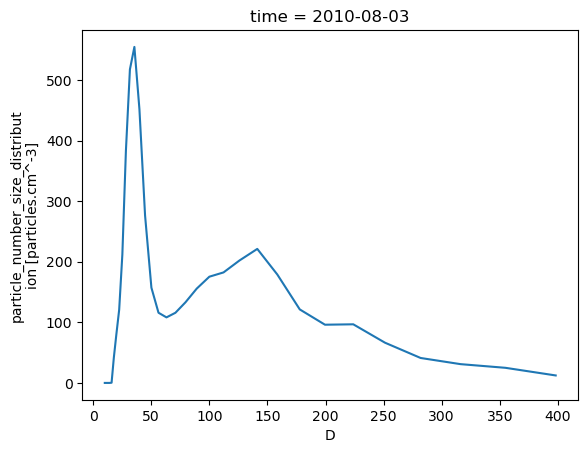

In [5]:
dist_1 = ds['pnsd'].isel(time=0)
dist_1.plot()

def plot_dist(variable, t): # function for plotting number size distribution for a given time
    dist = ds[variable].isel(time=t)
    dist.plot()

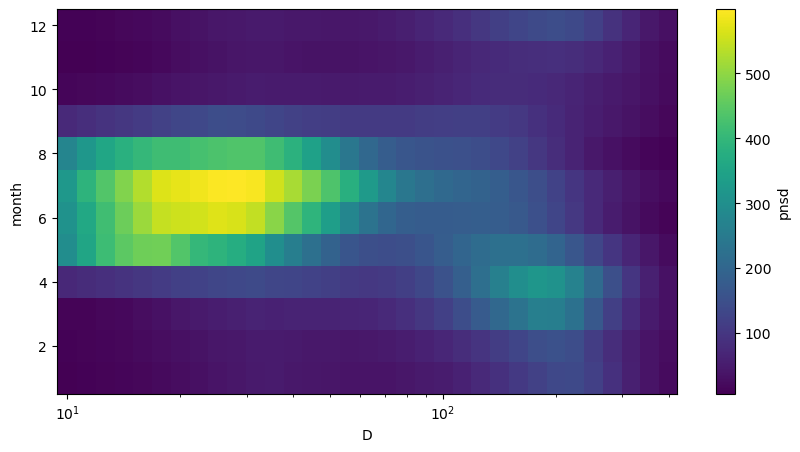

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
month_mean = ds['pnsd'].groupby(ds.time.dt.month).mean()
month_mean.plot()
ax.set_xscale('log')

In [7]:
ds_season = ds.groupby('time.season').mean(keep_attrs=True)

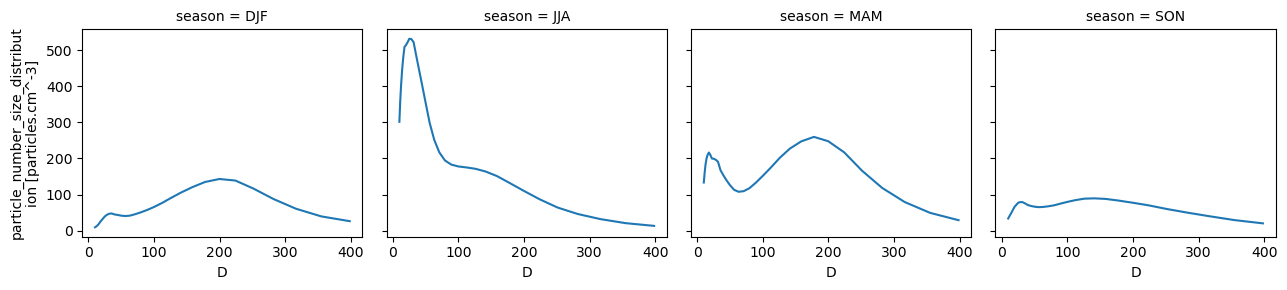

In [8]:
ds_season['pnsd'].plot(col='season')

In [9]:
# Making a dataframe
df = pd.DataFrame(ds.pnsd.values, ds.time, ds.D)
df.head()

,10.000,11.220,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,141.254,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107
2010-08-03 00:00:00,2.790497e-29,2.786005e-29,2.780935e-29,2.774283e-29,0.329741,41.606174,80.042240,120.892820,211.96954,383.428990,...,221.209820,178.977250,121.321720,96.090906,96.753904,66.386077,41.174992,30.989534,24.949570,12.333647
2010-08-03 01:00:00,2.789934e-29,2.785442e-29,2.779898e-29,2.528172e+00,12.974548,46.179508,141.295206,261.746105,315.75037,418.689125,...,85.695794,77.510495,77.746907,73.046753,50.889920,36.805352,25.441112,16.356454,11.408104,6.106511
2010-08-03 02:00:00,2.788325e-29,2.783747e-29,8.622146e+00,2.673972e+01,58.898629,100.978881,114.139330,141.574896,240.53080,327.122450,...,59.707636,53.033274,55.894537,52.390985,28.318534,19.184356,13.502628,8.935019,2.800536,3.287963
2010-08-03 03:00:00,2.787113e-29,2.782619e-29,2.777548e-29,2.770892e-29,1.415207,145.340800,148.781480,138.566340,246.65246,296.561560,...,182.845500,124.763920,133.017030,133.790430,64.798919,59.888534,43.716792,15.603318,16.124321,12.564497
2010-08-08 19:00:00,2.785696e-29,2.781117e-29,8.601954e+00,4.934555e+01,128.736955,210.290670,287.625065,334.561305,363.43000,358.072995,...,3.437324,1.959949,1.222223,0.898871,0.970009,0.691989,0.298961,0.005690,0.345479,0.783144


#### Finding the optimal k (number of clusters):

In [10]:
df.describe()

,10.000,11.220,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,141.254,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107
count,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,...,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04,5.313200e+04
mean,1.250638e+02,1.472622e+02,1.675036e+02,1.845569e+02,1.990807e+02,2.114686e+02,2.140854e+02,2.160548e+02,2.213825e+02,2.219974e+02,...,1.472334e+02,1.517104e+02,1.516202e+02,1.430552e+02,1.262640e+02,9.999934e+01,7.439412e+01,5.223507e+01,3.426870e+01,2.194304e+01
std,6.559779e+02,7.108893e+02,7.028472e+02,7.210722e+02,7.349052e+02,7.400234e+02,7.077335e+02,6.792891e+02,6.761447e+02,6.485391e+02,...,1.596316e+02,1.647599e+02,1.706566e+02,1.655136e+02,1.519354e+02,1.212825e+02,9.291079e+01,7.105404e+01,5.386824e+01,3.972660e+01
min,2.129550e-29,2.126170e-29,2.121627e-29,2.122920e-29,2.121105e-29,2.114443e-29,2.109589e-29,2.099396e-29,2.092112e-29,1.982091e-29,...,1.682741e-29,1.647067e-29,1.604406e-29,1.563965e-29,1.526628e-29,1.413993e-29,1.389839e-29,1.355980e-29,1.316102e-29,1.286877e-29
25%,1.011319e+00,1.284413e+00,3.240118e+00,5.039511e+00,7.152786e+00,1.060955e+01,1.414256e+01,1.814460e+01,2.169366e+01,2.452544e+01,...,4.304729e+01,4.247675e+01,3.928606e+01,3.335857e+01,2.633891e+01,1.889800e+01,1.349613e+01,9.383922e+00,6.124410e+00,3.761472e+00
50%,7.016288e+00,9.152810e+00,1.202604e+01,1.529895e+01,1.998066e+01,2.637089e+01,3.356888e+01,4.181856e+01,4.991856e+01,5.667965e+01,...,1.000522e+02,1.022415e+02,9.911840e+01,9.116297e+01,7.651579e+01,5.862825e+01,4.269992e+01,2.910467e+01,1.822160e+01,1.135785e+01
75%,3.329264e+01,3.877631e+01,4.668340e+01,5.776853e+01,7.334384e+01,9.237277e+01,1.122379e+02,1.336096e+02,1.541469e+02,1.690156e+02,...,2.006485e+02,2.061194e+02,2.046654e+02,1.927744e+02,1.701851e+02,1.381617e+02,1.035013e+02,7.103348e+01,4.437893e+01,2.689547e+01
max,7.985327e+04,7.470496e+04,3.408616e+04,2.987265e+04,2.418635e+04,1.749829e+04,2.340646e+04,2.223558e+04,3.130832e+04,3.755233e+04,...,3.310102e+03,2.100256e+03,1.888381e+03,1.929025e+03,1.851297e+03,2.080121e+03,2.246036e+03,2.280511e+03,2.104574e+03,1.692586e+03


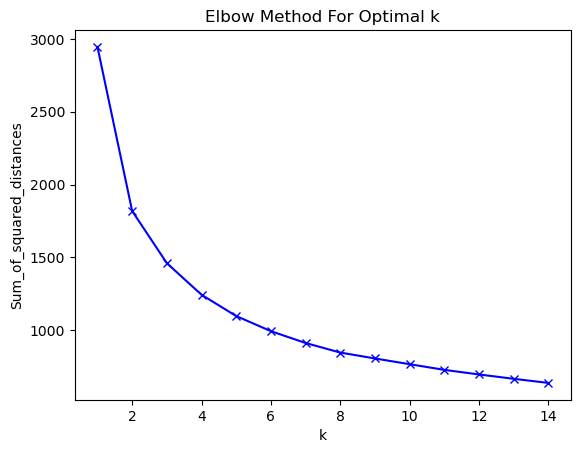

In [11]:
def k_elbow(df):
    mms = MinMaxScaler()
    mms.fit(df)
    data_transformed = mms.transform(df)
    
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data_transformed)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
k_elbow(df)

In [12]:
"""
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
"""

"\nplt.plot(K, Sum_of_squared_distances, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Sum_of_squared_distances')\nplt.title('Elbow Method For Optimal k')\nplt.show()\n"

The elbow is at k=5, indicating the optimal k for the particle number size is 5

### Clustering 

In [13]:
#Initialize the class object
kmeans = KMeans(n_clusters=5)

#predict the labels of clusters
label = kmeans.fit_predict(df)
label

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [14]:
df['cluster']=label
df.head()

,10.0,11.22,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107,cluster
2010-08-03 00:00:00,2.790497e-29,2.786005e-29,2.780935e-29,2.774283e-29,0.329741,41.606174,80.042240,120.892820,211.96954,383.428990,...,178.977250,121.321720,96.090906,96.753904,66.386077,41.174992,30.989534,24.949570,12.333647,0
2010-08-03 01:00:00,2.789934e-29,2.785442e-29,2.779898e-29,2.528172e+00,12.974548,46.179508,141.295206,261.746105,315.75037,418.689125,...,77.510495,77.746907,73.046753,50.889920,36.805352,25.441112,16.356454,11.408104,6.106511,0
2010-08-03 02:00:00,2.788325e-29,2.783747e-29,8.622146e+00,2.673972e+01,58.898629,100.978881,114.139330,141.574896,240.53080,327.122450,...,53.033274,55.894537,52.390985,28.318534,19.184356,13.502628,8.935019,2.800536,3.287963,0
2010-08-03 03:00:00,2.787113e-29,2.782619e-29,2.777548e-29,2.770892e-29,1.415207,145.340800,148.781480,138.566340,246.65246,296.561560,...,124.763920,133.017030,133.790430,64.798919,59.888534,43.716792,15.603318,16.124321,12.564497,0
2010-08-08 19:00:00,2.785696e-29,2.781117e-29,8.601954e+00,4.934555e+01,128.736955,210.290670,287.625065,334.561305,363.43000,358.072995,...,1.959949,1.222223,0.898871,0.970009,0.691989,0.298961,0.005690,0.345479,0.783144,0


In [15]:
D = ds.D
g = df.groupby('cluster')
median_clust = g.median()
percentile75 = g.quantile(0.75)
percentile25 = g.quantile(0.25)



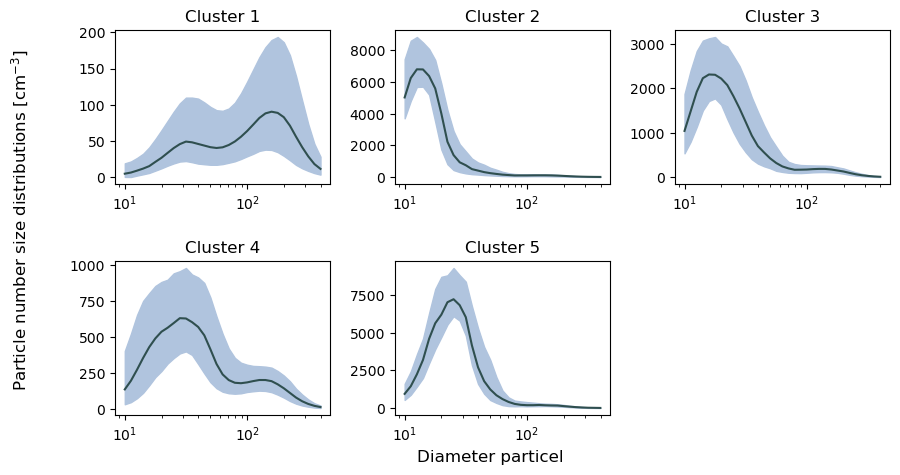

In [16]:

#def plot_cluster(median, percentile25, percentile75)
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(D, percentile25.iloc[i], percentile75.iloc[i], color='lightsteelblue')
    ax.plot(D, median_clust.iloc[i], color='darkslategrey')
    ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('Diameter particel')
fig.supylabel('Particle number size distributions [cm$^{-3}$]');

Could also maybe look at the normalized clusters^

### normalized cluster

In [17]:
df_norm = df.div(df.max(axis=1), axis=0)
df_norm.head()

,10.0,11.22,12.589,14.125,15.849,17.783,19.953,22.387,25.119,28.184,...,158.489,177.828,199.526,223.872,251.189,281.838,316.228,354.813,398.107,cluster
2010-08-03 00:00:00,5.031303e-32,5.023205e-32,5.014064e-32,5.002070e-32,0.000595,0.075016,0.144317,0.217971,0.382184,0.691328,...,0.322698,0.218745,0.173253,0.174449,0.119695,0.074239,0.055875,0.044984,0.022238,0.0
2010-08-03 01:00:00,4.872907e-32,4.865062e-32,4.855378e-32,4.415712e-03,0.022661,0.080657,0.246787,0.457167,0.551491,0.731284,...,0.135380,0.135793,0.127584,0.088884,0.064284,0.044436,0.028568,0.019925,0.010666,0.0
2010-08-03 02:00:00,6.567502e-32,6.556720e-32,2.030823e-02,6.298159e-02,0.138727,0.237841,0.268839,0.333459,0.566536,0.770490,...,0.124912,0.131652,0.123399,0.066700,0.045186,0.031804,0.021045,0.006596,0.007744,0.0
2010-08-03 03:00:00,4.371393e-32,4.364346e-32,4.356391e-32,4.345953e-32,0.002220,0.227957,0.233353,0.217332,0.386857,0.465136,...,0.195684,0.208628,0.209841,0.101633,0.093931,0.068567,0.024473,0.025290,0.019707,0.0
2010-08-08 19:00:00,7.665014e-32,7.652415e-32,2.366881e-02,1.357773e-01,0.354228,0.578628,0.791418,0.920566,1.000000,0.985260,...,0.005393,0.003363,0.002473,0.002669,0.001904,0.000823,0.000016,0.000951,0.002155,0.0


/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


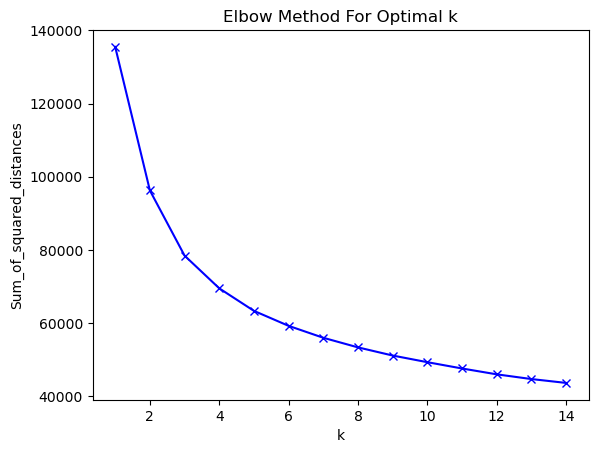

In [18]:
k_elbow(df_norm)

The elbow is at k=6, indicating the optimal k for the particle number size is 6

In [19]:
#Initialize the class object
kmeans = KMeans(n_clusters=5)

#predict the labels of clusters
label = kmeans.fit_predict(df_norm)
label

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([4, 4, 4, ..., 1, 1, 1], dtype=int32)

In [20]:
df_norm['cluster']=label

In [21]:
g = df_norm.groupby('cluster')
median_clust = g.median()
percentile75 = g.quantile(0.75)
percentile25 = g.quantile(0.25)

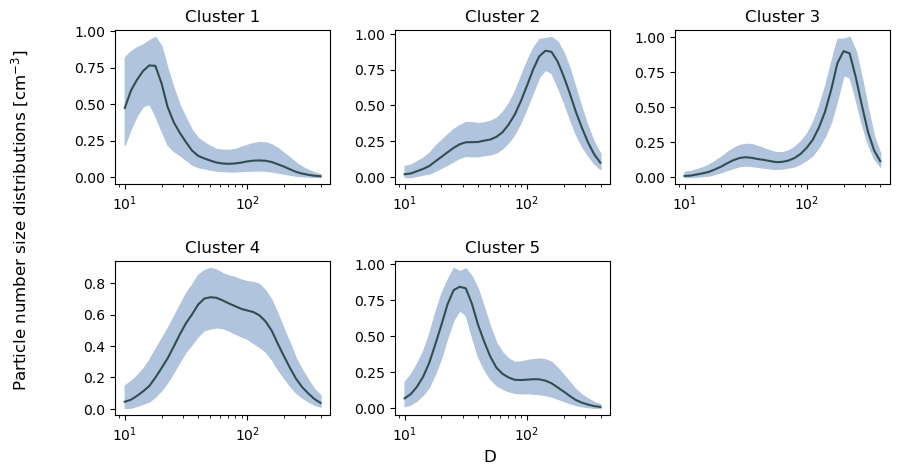

In [22]:
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(D, percentile25.iloc[i], percentile75.iloc[i], color='lightsteelblue')
    ax.plot(D, median_clust.iloc[i], color='darkslategrey')
    ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('D')
fig.supylabel('Particle number size distributions [cm$^{-3}$]');

#### Accumulated precipitation for each cluster

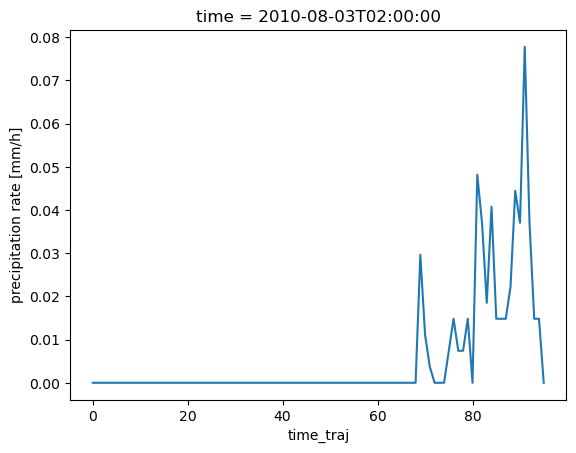

In [23]:
ds['Rainfall']
plot_dist('Rainfall', 2)

In [ ]:
accum_rain = ds['Rainfall'].cumsum(axis=1)
ds['accum_rainfall'] = accum_rain

In [25]:
# Making a dataframe
df_rain = pd.DataFrame(ds.accum_rainfall.values, ds.time, ds.time_traj)
df_rain_norm = df_rain.div(df.max(axis=1), axis=0)
df_rain_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
2010-08-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614,0.000614
2010-08-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000505,0.000524,0.000543,0.000543,0.000543,0.000569,0.000569,0.000569,0.000569,0.000569
2010-08-03 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000637,0.000672,0.000724,0.000829,0.000916,0.001099,0.001186,0.001221,0.001256,0.001256
2010-08-03 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000168,0.000250,0.000302,0.000319,0.000331,0.000401,0.000453,0.000529,0.000552,0.000587
2010-08-08 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002313,0.002374,0.002436,0.002639,0.002833,0.002976,0.003037,0.003139,0.003180,0.003200


In [26]:
df_rain_norm['cluster']=label
time_traj = ds.time_traj

In [27]:
g = df_rain_norm.groupby('cluster')
rain_median_clust = g.median()
rain_percentile75 = g.quantile(0.75)
rain_percentile25 = g.quantile(0.25)

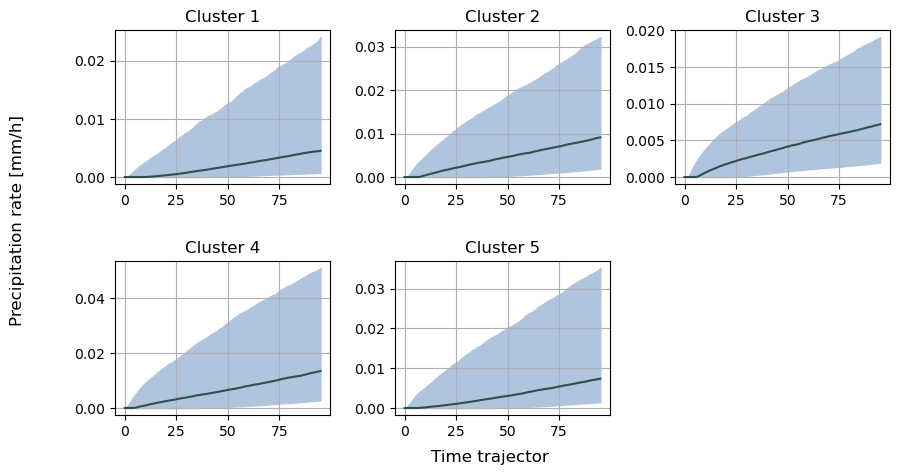

In [28]:
fig = plt.figure(figsize=(10,5))

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.fill_between(time_traj, rain_percentile25.iloc[i], rain_percentile75.iloc[i], color='lightsteelblue')
    ax.plot(time_traj, rain_median_clust.iloc[i], color='darkslategrey')
    #ax.set_xscale('log')
    ax.set_title('Cluster '+str(i+1))
    plt.grid()
    

plt.subplots_adjust(wspace=0.3, hspace=0.5)
#fig.suptitle('Clusters', fontsize=16)
fig.supxlabel('Time trajector')
fig.supylabel('Precipitation rate [mm/h]');

### Trajector map

#### Things to do:

- first add accumulated rainfall to the dataset for 6, or 96 hours for example. Then make it into a dataframe and add the clusters. use groupby, and plot (make it into a function first)


- Make distrubutions that fit differents modes of the particle number size distribution. (Usally two modes (for small and larger))
- Plot clusters at each trajectory

- plot trends of precipitation and aerosols on a map


#### Model data


TODO: Plot trend in AOD in relative change to compare with trend in precipitation

In [50]:
# Read in multiple piControl files:

list_of_files = [
    '../../Data/ccn_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/cdnc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/co2_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/dms_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emibc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emibvoc_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emidms_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emidust_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emioa_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiso2_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiso4_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/emiss_AERmon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    #'../../Data/od550oa_AERmon_NorESM2-LM_piControl_r1i1p1f1_gn_171001-171912.nc',
    '../../Data/pr_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/prc_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc',
    '../../Data/ts_Amon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc'
]
ds = xr.open_mfdataset(list_of_files, combine='by_coords', compat='override', use_cftime=True)#concat_dim='time',combine='by_coords')
ds

<xarray.Dataset>
Dimensions:    (time: 120, bnds: 2, lev: 32, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1200-01-16 12:00:00 ... 1209-12-16 12:00:00
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables: (12/25)
    time_bnds  (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    p0         float64 ...
    a          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    ...         ...
    emiso2     (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    emiso4     (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    emiss      (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    prc        (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
    ts         (time, lat, lon) float32 dask.array<chunksize=(120, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               cdnc
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/9514c407-05be-44d4-9aee-cdf51d923312

In [36]:
# Reads in downloaded model data

#file = '../../Data/ccn_AERmon_NorESM2-MM_abrupt-4xCO2_r1i1p1f1_gn_000101-001012.nc'
#ds = xr.open_dataset(file)#, combine='by_coords')
#ds

In [53]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [54]:
#print(col.df.variable_id.unique())

In [55]:
cat = col.search(source_id=['NorESM2-MM'], experiment_id=['ssp585'], table_id=['Amon', 'Emon'], variable_id=['tas', 'conccn', 'prc', 'pr', 'concnmcn', 'conccmcn', 'ec550aer'], member_id=['r1i1p1f1'])
#cat2 = col.search(source_id=['NorESM2-MM'], experiment_id=['ssp585'], table_id=['Emon'], variable_id=['conccn', 'concnmcn', 'conccmcn'])#, member_id=['r1i1p1f1'])

In [56]:
#CMIP6.DAMIP.NCC.NorESM2-LM.hist-GHG
#CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-GHG.r1i1p1f3.Amon.pr.gn 
#CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-GHG.r1i1p1f1.Emon.ec550aer.gn 

#CMIP6.CMIP.MOHC.UKESM1-0-LL.abrupt-4xCO2.r1i1p1f2.Emon.conccn.gn 
cat2 = col.search(source_id=['UKESM1-0-LL'], experiment_id=['abrupt-4xCO2'], table_id=['Amon','Emon'], variable_id=[ 'prc', 'pr', 'ec550aer','conccn', 'concnmcn', 'conccmcn'], member_id=['r1i1p1f2'])

In [57]:
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict2


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


{'CMIP.MOHC.UKESM1-0-LL.abrupt-4xCO2.Amon.gn': <xarray.Dataset>
 Dimensions:    (lat: 144, bnds: 2, lon: 192, member_id: 1, time: 1800)
 Coordinates:
   * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
     lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
   * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
     lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
   * time       (time) object 1850-01-16 00:00:00 ... 1999-12-16 00:00:00
     time_bnds  (time, bnds) object dask.array<chunksize=(1800, 2), meta=np.ndarray>
   * member_id  (member_id) <U8 'r1i1p1f2'
 Dimensions without coordinates: bnds
 Data variables:
     pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 144, 192), meta=np.ndarray>
     prc        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 554, 144, 192), meta=np.ndarray>
 Attributes: (12/47)
     sub_experiment:       

In [58]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [77]:
dset = list(dset_dict.values())[0]
dset = dset.compute()
dset

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 1032)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 7.879e-07 ... 1.083e-05
    prc        (member_id, time, lat, lon) float32 0.0 0.0 ... 2.667e-07
    tas        (member_id, time, lat, lon) float32 243.8 243.8 ... 265.9 265.9
Attributes: (12/54)
    sub_experiment:            none
    experiment_id:             ssp585
    intake_esm_varname:        pr\nprc\ntas
    cmor_version:              3.5.0
    source:                    NorESM2-MM (2017): \naerosol: OsloAero\natmos:...
    table_id:                  Amon
    ...                        ...
    grid_label:                gn
    physics_index:             1
    run_variant:               N/A
    parent_experiment_id:      historical
    status:                    2020-05-01;created; by gcs.cmip6.ldeo@gmail.com
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-MM.ssp585.Amon.gn

In [60]:
dset2 = list(dset_dict2.values())[0]
dset2 = dset2.compute()
dset2

<xarray.Dataset>
Dimensions:    (lat: 144, bnds: 2, lon: 192, member_id: 1, time: 1800)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 -90.0 -88.75 -88.75 ... 88.75 88.75 90.0
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 0.0 1.875 1.875 3.75 ... 358.1 358.1 360.0
  * time       (time) object 1850-01-16 00:00:00 ... 1999-12-16 00:00:00
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 2000-01-01 00:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 3.504e-06 ... 2.299e-05
    prc        (member_id, time, lat, lon) float32 0.0 0.0 ... 5.812e-06
Attributes: (12/47)
    sub_experiment:          none
    experiment_id:           abrupt-4xCO2
    intake_esm_varname:      pr\nprc
    cmor_version:            3.4.0
    source:                  UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mode\...
    table_id:                Amon
    ...                      ...
    grid:                    Native N96 grid; 192 x 144 longitude/latitude
    realm:                   atmos
    grid_label:              gn
    physics_index:           1
    parent_experiment_id:    piControl
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.abrupt-4xCO2.Amon.gn

In [61]:
# decadal precipitation

NorESM_yearly = dset.resample(time="Y").mean()*86400 #mm/decades
NorESM_yearly

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, member_id: 1, time: 86)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    height     float64 2.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 2015-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float64 0.2018 0.2018 ... 0.9593
    prc        (member_id, time, lat, lon) float64 0.0 0.0 ... 0.01395 0.01396
    tas        (member_id, time, lat, lon) float64 1.965e+07 ... 2.308e+07

In [62]:
mean_NorESM_yearly = dset.mean()
anomaly = NorESM_yearly-mean_NorESM_yearly

In [63]:
lat_zeppelin = 78.54
lon_zeppelin = 52.53
zeppelin_anomali = anomaly.sel(lat=lat_zeppelin, lon = lon_zeppelin, method ='nearest')

Text(0.5, 0.98, 'precipitation anomli at Zepplin Observatory')

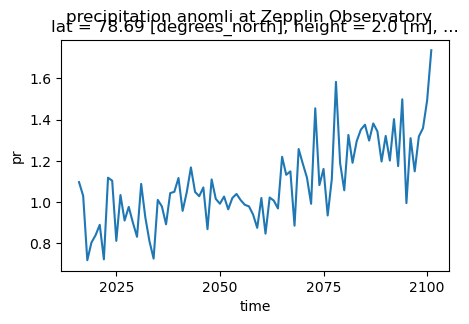

In [64]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
zeppelin_anomali['pr'].plot()
fig.suptitle('precipitation anomli at Zepplin Observatory', fontsize=12)

In [65]:
! pip install pymannkendall

In [69]:
dset.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    height   float64 2.0
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [66]:
df_NorESM_time = dset['time'].to_dataframe().index.to_datetimeindex()
df_NorESM_time

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_982/707129345.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  df_NorESM_time = dset['time'].to_dataframe().index.to_datetimeindex()


DatetimeIndex(['2015-01-16 12:00:00', '2015-02-15 00:00:00',
               '2015-03-16 12:00:00', '2015-04-16 00:00:00',
               '2015-05-16 12:00:00', '2015-06-16 00:00:00',
               '2015-07-16 12:00:00', '2015-08-16 12:00:00',
               '2015-09-16 00:00:00', '2015-10-16 12:00:00',
               ...
               '2100-03-16 12:00:00', '2100-04-16 00:00:00',
               '2100-05-16 12:00:00', '2100-06-16 00:00:00',
               '2100-07-16 12:00:00', '2100-08-16 12:00:00',
               '2100-09-16 00:00:00', '2100-10-16 12:00:00',
               '2100-11-16 00:00:00', '2100-12-16 12:00:00'],
              dtype='datetime64[ns]', length=1032, freq=None)

In [67]:
import pymannkendall as mk
mk.original_test(df_NorESM_time)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=48.105460512149676, Tau=1.0, s=531996.0, var_s=122299969.33333333, slope=2629800000000000.0, intercept=1.4214069e+18)

In [73]:
# function to remove dimensions with only one value
def remove_singledim(ds):
    for dim in ds.dims:
        
        if len(ds[dim]) == 1:
            ds = ds.squeeze(dim)
    return ds

In [71]:
#NorESM_yearly.squeeze('member_id')

In [75]:
NorESM_yearly = remove_singledim(NorESM_yearly)
NorESM_yearly

<xarray.Dataset>
Dimensions:    (lat: 192, bnds: 2, lon: 288, time: 86)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    height     float64 2.0
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
    member_id  <U8 'r1i1p1f1'
  * time       (time) object 2015-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 0.2018 0.2018 0.2018 ... 0.9592 0.9593
    prc        (time, lat, lon) float64 0.0 0.0 0.0 ... 0.01396 0.01395 0.01396
    tas        (time, lat, lon) float64 1.965e+07 1.965e+07 ... 2.308e+07

In [ ]:
def trend(ds, variable, season):
    
    # create a dataset with same lon and lat as the precipitation dataset
    ds_trend = xr.Dataset({'lat': ds.lat,'lon': ds.lon})
    # add ds_trend_DJF to ds_NorESM2_MM_precip_season_trend
    # ds_season = ds.groupby('time.season').mean(keep_attrs=True) eks
    ds_trend['mk_trend'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)
    ds_trend['mk_intercept'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)
    ds_trend['mk_p_val'] = (['lat', 'lon'], np.zeros((ds.lat.shape[0], ds.lon.shape[0]))*np.nan)  
    
    for ilat in range(ds[variable].shape[1]):
        for ilon in range(ds[variable].shape[2]):
            ts = ds[variable][:, ilat, ilon]
            results = mk.original_test(ts)
            ds_trend['mk_trend'][ilat, ilon] = results[7]
            ds_trend['mk_intercept'][ilat, ilon] = results[8]
            ds_trend['mk_p_val'][ilat, ilon] = results[2]
    return ds_trend



In [ ]:
pr_trend_NorESM_yearly = trend(NorESM_yearly, 'pr', 'JJA')

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
def dot_signif(ds, ax):
    for ilat, lat in enumerate(ds.lat):
        for ilon, lon in enumerate(ds.lon):
            if ds.mk_p_val.isel(lat=ilat, lon=ilon) < 0.05:
                if (ilon % 3 == 0) and (ilat % 3 == 0):# and lat<70:
                    ax.plot(lon, lat, marker='o', color='k', transform=ccrs.PlateCarree(), markersize=1)


In [ ]:


def plot_map_trend(ds, var, levels=6, extent=[-180,180,90,50], vmin=-0.02, vmax=0.02):
    '''
        Plots the trend on a map from the model data
        
    Args:
    -----
        var    [DataArray]   :   An xarray contining data about the conditions 
        levels [int]         :   Levels in the plot
        extent [list]        :   A list of the extent of the plot
    '''
    
    
    sat_proj = ccrs.NorthPolarStereo()
    fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':sat_proj})
    ds[var].plot(facecolor="gray",
        ax = ax,
        cbar_kwargs={
            'orientation':'vertical',
            'shrink':.8
            },                 
        transform=ccrs.PlateCarree(),
        #levels=levels,
        vmin=vmin,
        vmax=vmax, cmap="RdBu"
        #robust=True
        )


    dot_signif(ds, ax)
    
    #cbar.set_clim(min, max)
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True)
    ax.coastlines()
    fig.tight_layout()
    


In [ ]:
plot_map_trend(pr_trend_NorESM_yearly, 'mk_trend')

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot(111, projection=ccrs.Robinson())
pr_trend_NorESM_yearly.mk_trend.plot(facecolor="gray", transform=ccrs.PlateCarree(), ax=ax)
# coastlines
ax.coastlines()

dot_signif(pr_trend_NorESM_yearly, ax)


In [ ]:
#plot_map_trend(pr_trend_NorESM_yearly, 'mk_p_val')

In [ ]:
NorESM_yearly_skip_time1 = NorESM_yearly.drop_isel(time=0)


In [ ]:
# trend in percentage 
percentage_NorESM_yearly = ((NorESM_yearly_skip_time1-NorESM_yearly.isel(time=0))/NorESM_yearly.isel(time=0)*100)
percentage_NorESM_yearly

In [ ]:
pr_trend_percentage_NorESM_yearly = trend(percentage_NorESM_yearly, 'pr', 'JJA')

In [ ]:
plot_map_trend(pr_trend_percentage_NorESM_yearly, 'mk_trend', vmin=-2.5, vmax=2.5)

#### For aerosol

- DAMIP (name of mip)
- hist_GHG (experiment)
- piControl (control, reference)

So hist GHG should not increase the amount of aerosols due to global warming, and thus we can look at the effect of precipitation